In [1]:
import pandas as pd
import numpy as np
import datetime as dt
#from datetime import timedelta

import matplotlib.pyplot as plt
import seaborn as sns

from sksurv.linear_model import CoxnetSurvivalAnalysis
from sksurv.linear_model import CoxPHSurvivalAnalysis
from lifelines import CoxPHFitter

from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.exceptions import FitFailedWarning
import sksurv.util
import warnings
from lifelines.utils import k_fold_cross_validation

from sklearn.linear_model import LassoCV

from sksurv.preprocessing import OneHotEncoder


df=pd.read_csv("../1_data/private/preprocessed_data.csv")

mask = (df['Visit_yr'] >= 2017) 
df = df.loc[mask]

df_cox=df 

#keep only wb and drbc or rbc
#wb=['WB', "DEF PROD", 'WBSB', 'WBMED', 'RBCAPH']
#df= df.loc[(df['donation_product_x'] == 'WB') | (df['donation_product_x']== 'RBCAPH')|(df['donation_product_x'] == 'DEF PROD')]
df['donation_product_x'].value_counts()

C:\Users\jagir\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (17) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


WB          3729564
DEF PROD     439099
RBCAPH         5882
Name: donation_product_x, dtype: int64

In [3]:
#for cox fitter
df_cox2= df.loc[:,['time_to_return2', 'CENSORED','Visit_Age',  'first_time' , 'Fixed_mobile' ,'sex', 'donation_product_x' ,'race', 'OUTCOME_TYPE', 
                 'cum_lifetime_donations', 'unit_rbc_loss', 'rbc_loss_last_12_months', 
                 'rbc_loss_last_24_months', 'days_since_last_rbc_loss', 'days_since_last_drbc_loss']]


X3=pd.get_dummies(df_cox2)
X3.fillna(0, inplace=True)
# add interactions
X3['first_time*fixed']=X3["first_time"]*X3['Fixed_mobile']
X3['first_time*hgb']=X3["first_time"]*X3['OUTCOME_TYPE_low hgb']
X3['hgb*fixed']=X3["OUTCOME_TYPE_low hgb"]*X3['Fixed_mobile']

y3= X3['CENSORED']

pd.set_option('display.max_columns', 48)
X3.head()


,time_to_return2,CENSORED,Visit_Age,first_time,Fixed_mobile,cum_lifetime_donations,unit_rbc_loss,rbc_loss_last_12_months,rbc_loss_last_24_months,days_since_last_rbc_loss,days_since_last_drbc_loss,sex_F,sex_M,donation_product_x_DEF PROD,donation_product_x_RBCAPH,donation_product_x_WB,race_African Black,race_Asian,race_Mixed Race,race_White,race_unknown,OUTCOME_TYPE_completed,OUTCOME_TYPE_low hgb,OUTCOME_TYPE_no draw,OUTCOME_TYPE_other deferral,first_time*fixed,first_time*hgb,hgb*fixed
4,379.0,1,40.9,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0
5,72.0,1,41.9,0,1,23.0,1.0,1.0,2.0,379.0,3650.0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0
6,68.0,1,42.1,0,1,24.0,1.0,2.0,3.0,72.0,3650.0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0
7,67.0,1,42.3,0,1,25.0,1.0,3.0,4.0,68.0,3650.0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0
8,59.0,1,42.5,0,1,26.0,1.0,4.0,5.0,67.0,3650.0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0


In [4]:

# Split the data into training and test sets
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size=0.7, random_state=0)

# Set up LassoCV model to find optimal penalty
model = LassoCV(cv=5, random_state=0)
model.fit(X_train3, y_train3)

# Get optimal penalty value
penalty = model.alpha_

print(penalty)

# Set up CoxPHFitter model with Lasso penalty
cph = CoxPHFitter(penalizer=penalty)

# Use k-fold cross-validation to fit the model
kf = KFold(n_splits=5, shuffle=True, random_state=0)
scores = []
for train_idx, val_idx in kf.split(X_train3):
    X_train_fold, X_val_fold = X_train3.iloc[train_idx], X_train3.iloc[val_idx]
    y_train_fold, y_val_fold = y_train3.iloc[train_idx], y_train3.iloc[val_idx]
    
    cph.fit(X_train_fold, duration_col='time_to_return2', event_col='CENSORED')
    CV_score = cph.score(X_val_fold, scoring_method='concordance_index')
    scores.append(CV_score)

# Print average cross-validation score
print('Average cross-validation score:', sum(scores)/len(scores))


# Fit the model on the entire training set
cph.fit(X_train3, duration_col='time_to_return2', event_col='CENSORED')

# Print summary of the model
cph.print_summary()

0.2551151639837501
Average cross-validation score: 0.656363776657772


<lifelines.CoxPHFitter: fitted with 1.25236e+06 total observations, 176182 right-censored observations>
             duration col = 'time_to_return2'
                event col = 'CENSORED'
                penalizer = 0.2551151639837501
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 1.25236e+06
number of events observed = 1.07618e+06
   partial log-likelihood = -13976798.41
         time fit was run = 2023-05-24 19:14:44 UTC

---
                              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                           
Visit_Age                     0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
first_time                   -0.17       0.84       0.00            -0.18            -0.17                 0.83                 0.85
Fixed_mobile                  0.19       1.21       0.00             0.19             0.20                 1.21                 1.22
cum_lifetime_donations        0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
unit_rbc_loss                 0.07       1.07       0.00             0.06             0.08                 1.07                 1.08
rbc_loss_last_12_months       0.08       1.08       0.00             0.08             0.08                 1.08                 1.08
rbc_loss_last_24_months       0.04       1.04       0.00             0.04             0.04                 1.04                 1.04
days_since_last_rbc_loss     -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
days_since_last_drbc_loss     0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
sex_F                        -0.03       0.97       0.00            -0.03            -0.02                 0.97                 0.98
sex_M                         0.03       1.03       0.00             0.02             0.03                 1.02                 1.03
donation_product_x_DEF PROD  -0.01       0.99       0.01            -0.02             0.00                 0.99                 1.00
donation_product_x_RBCAPH     0.00       1.00       0.02            -0.04             0.05                 0.96                 1.05
donation_product_x_WB         0.01       1.01       0.00            -0.00             0.01                 1.00                 1.01
race_African Black            0.01       1.01       0.00             0.01             0.02                 1.01                 1.02
race_Asian                   -0.11       0.90       0.00            -0.11            -0.10                 0.89                 0.91
race_Mixed Race               0.03       1.03       0.00             0.02             0.03                 1.02                 1.03
race_White                    0.01       1.01       0.00             0.01             0.02                 1.01                 1.02
race_unknown                 -0.08       0.92       0.01            -0.10            -0.07                 0.90                 0.94
OUTCOME_TYPE_completed       -0.02       0.98       0.00            -0.03            -0.01                 0.97                 0.99
OUTCOME_TYPE_low hgb         -0.11       0.89       0.01            -0.12            -0.10                 0.88                 0.90
OUTCOME_TYPE_no draw          0.15       1.17       0.01             0.14             0.17                 1.15                 1.18
OUTCOME_TYPE_other deferral   0.09       1.09       0.01             0.08             0.10                 1.08                 1.10
first_time*fixed              0.03       1.03       0.01             0.02             0.05                 1.02                 1.05
first_time*hgb               -0.04       0.96       0.02    

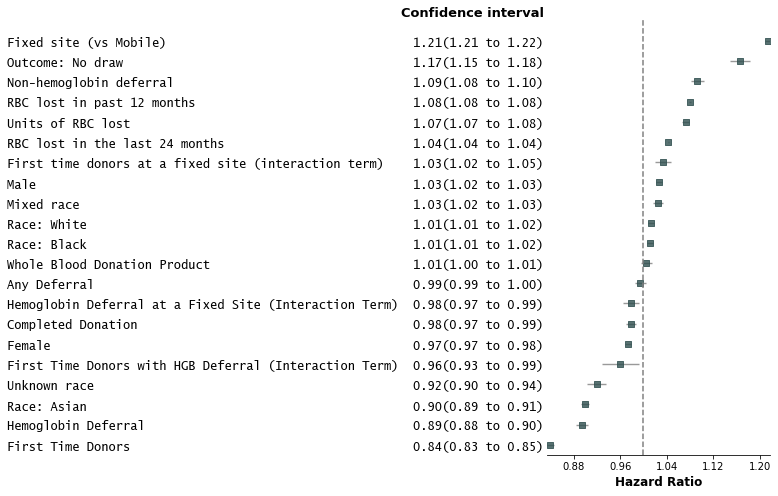

In [11]:
from forestplot import forestplot
# Extract the coefficients and their confidence intervals

ci = cph.confidence_intervals_.iloc[[2, 21, 22, 5, 4, 6, 23, 10, 16, 17, 14, 13, 11, 25, 19, 9, 24, 18, 15, 20, 1],:]

coef = cph.hazard_ratios_[['Fixed_mobile', 'OUTCOME_TYPE_no draw', "OUTCOME_TYPE_other deferral",
                           'rbc_loss_last_12_months','unit_rbc_loss','rbc_loss_last_24_months', 
                           'first_time*fixed',  'sex_M','race_Mixed Race',  'race_White', 
                           'race_African Black', 'donation_product_x_WB', 'donation_product_x_DEF PROD',
                           'hgb*fixed', 'OUTCOME_TYPE_completed', 'sex_F', 'first_time*hgb',
                           'race_unknown','race_Asian', 'OUTCOME_TYPE_low hgb', 'first_time']]

covariate=['Fixed site (vs Mobile)', 'Outcome: No draw', 'Non-hemoglobin deferral',
                      'RBC lost in past 12 months','Units of RBC lost',  'RBC lost in the last 24 months', 
                      'First time donors at a fixed site (interaction term)', 'Male', 'Mixed race','Race: White',
                      'Race: Black', 'Whole Blood Donation Product', 'Any Deferral', 'Hemoglobin Deferral at a Fixed Site (Interaction Term)',
         'Completed Donation', 'Female', 'First Time Donors with HGB Deferral (Interaction Term)', 'Unknown race', 
                      'Race: Asian', 'Hemoglobin Deferral', 'First Time Donors']

# Create a dataframe to store the coefficients and their confidence intervals
data = pd.DataFrame({'covariate': covariate, 'coef': coef, 'lower': ci['95% lower-bound'], 'upper': ci['95% upper-bound']})

data['lower'] = np.exp(data['lower'])
data['upper'] = np.exp(data['upper'])

# Sort the dataframe in descending order of coefficients
data = data.sort_values('coef', ascending=False)

# Create a numpy array of indices for each covariate
ind = np.arange(data.shape[0])


fp=forestplot(data,  # the dataframe with results data
              estimate="coef",  # col containing estimated effect size 
              ll="lower", hl="upper",  # columns containing conf. int. lower and higher limits
              varlabel="covariate",  # column containing variable label
              ylabel="Confidence interval",  # y-label title
              xlabel="Hazard Ratio",  # x-label title
             )
fp.axvline(x=1.00, linestyle='--', color='gray')
plt.show()

In [12]:
def plot_coefficients(coefs, n_highlight):
    _, ax = plt.subplots(figsize=(9, 6))
    n_features = coefs.shape[0]
    alphas = coefs.columns
    for row in coefs.itertuples():
        ax.semilogx(alphas, row[1:], ".-", label=row.Index)

    alpha_min = alphas.min()
    top_coefs = coefs.loc[:, alpha_min].map(abs).sort_values().tail(n_highlight)
    for name in top_coefs.index:
        coef = coefs.loc[name, alpha_min]
        plt.text(
            alpha_min, coef, name + "   ",
            horizontalalignment="right",
            verticalalignment="center"
        )

    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.grid(True)
    ax.set_xlabel("alpha")
    ax.set_ylabel("coefficient")

In [ ]:
print(list(df.columns))
#for sklearn
#get dummies of categorical variables
df_cox= df.loc[:,['Visit_Age',  'first_time' , 'Fixed_mobile' ,'sex', 'donation_product_x' ,'ABO_RH' ,'race', 'OUTCOME_TYPE', 
                 'cum_lifetime_donations', 'unit_rbc_loss', 'rbc_loss_last_12_months', 
                 'rbc_loss_last_24_months', 'days_since_last_rbc_loss', 'days_since_last_drbc_loss']]

X=pd.get_dummies(df_cox)

# add interactions
X['first_time*fixed']=X["first_time"]*X['Fixed_mobile']
X['first_time*hgb']=X["first_time"]*X['OUTCOME_TYPE_low hgb']
X['hgb*fixed']=X["OUTCOME_TYPE_low hgb"]*X['Fixed_mobile']

X.fillna(0, inplace=True)
X.head()


In [ ]:
# Lasso Penalized Cox Proportional Hazard Model

   #Structured array

Y= sksurv.util.Surv.from_dataframe('CENSORED', 'time_to_return', df)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.90, random_state=42)

#fit the model
cox_lasso = CoxnetSurvivalAnalysis(l1_ratio=1, alpha_min_ratio='auto', fit_baseline_model=True)
#cox = CoxPHSurvivalAnalysis()
cox_lasso.fit(X_train, Y_train)


#print(cox_lasso.coef_)


coefficients_lasso = pd.DataFrame(
    cox_lasso.coef_,
    index=X_train.columns,
    columns=np.round(cox_lasso.alphas_, 5)
)

plot_coefficients(coefficients_lasso, n_highlight=5) 


